In [1]:
import pandas as pd
data = pd.read_csv('/content/block.csv')

### Dataset

In [2]:
# Dropping rows with any missing values
data_dropped = data.dropna()

# Filling the remaining missing values with a specific value, for example, filling NaNs with 0
data_processed = data_dropped.fillna(0)

# Displaying the processed data
print(data_processed.head())

  member_name                     email  gender   location   employer  \
0       Chipi        ajimmison0@sun.com  female     Kwekwe       Vipe   
1       Femba     rsoonhouse1@google.it  female  Marondera       Mudo   
2        Geta  bchecchetelli2@house.gov  female     Rusape     Skaboo   
3    Tichaona          mgarman3@psu.edu  female     Rusape  Babbleset   
4       Chisa     ccough4@biglobe.ne.jp  female   Bulawayo   Flipopia   

  relationship patient_name  patient_suffix patient_dob  \
0  Grandfather      Mabhena             789  09-11-1997   
1      Husband      Sithole             860   1/14/1992   
2       Mother        Chipi             374  07-03-1999   
3       Father       Jembwa             729   7/31/1978   
4       Father         Foto             716  12/28/1992   

                   cause  Fee_Charged  membership_period  number_of_claims  \
0                  Other         3798               1541                 2   
1                  Other        48905             

### Feature Extraction using PCA

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
# Extract the numeric columns for feature extraction
numeric_columns = ['patient_suffix','Fee_Charged','membership_period','number_of_claims','number_of_dependants','label']

# Select the numeric columns for feature extraction
X = data[numeric_columns]

# Apply feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
num_components = 5
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the extracted PCA features
pca_columns = [f'PCA_{i+1}' for i in range(num_components)]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)

# Define meaningful names for the actual columns
actual_column_names = ['patient_suffix','Fee_Charged','membership_period','number_of_claims','number_of_dependants','label']

# Define the mapping of PCA feature columns to actual names based on their index
pca_feature_mapping = {
    pca_columns[i]: actual_column_names[i] + '_PCA' for i in range(num_components)
}


pca_df.rename(columns=pca_feature_mapping, inplace=True)

final_df_with_actual_names = pd.concat([data, pca_df], axis=1)

print("Final DataFrame with actual column names for PCA features:")
print(final_df_with_actual_names.head())


Final DataFrame with actual column names for PCA features:
  member_name                     email  gender   location   employer  \
0       Chipi        ajimmison0@sun.com  female     Kwekwe       Vipe   
1       Femba     rsoonhouse1@google.it  female  Marondera       Mudo   
2        Geta  bchecchetelli2@house.gov  female     Rusape     Skaboo   
3    Tichaona          mgarman3@psu.edu  female     Rusape  Babbleset   
4       Chisa     ccough4@biglobe.ne.jp  female   Bulawayo   Flipopia   

  relationship patient_name  patient_suffix patient_dob  \
0  Grandfather      Mabhena             789  09-11-1997   
1      Husband      Sithole             860   1/14/1992   
2       Mother        Chipi             374  07-03-1999   
3       Father       Jembwa             729   7/31/1978   
4       Father         Foto             716  12/28/1992   

                   cause  Fee_Charged  membership_period  number_of_claims  \
0                  Other         3798               1541             

### Feature selection using RFE

In [5]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Assuming 'final_df_with_actual_names' contains the DataFrame after PCA and feature concatenation

# Extract only numeric columns for feature selection
numeric_columns = final_df_with_actual_names.select_dtypes(include=['float64', 'int64']).columns
features = final_df_with_actual_names[numeric_columns]

# Remove the target column from features if it's included
target_column = 'label'
if target_column in features:
    features = features.drop(columns=[target_column])

# Initialize the model for feature selection (Random Forest Classifier)
model = RandomForestClassifier()

# Initialize Recursive Feature Elimination (RFE)
num_features_to_select = 3  # Number of features to select
rfe = RFE(model, n_features_to_select=num_features_to_select)

# Fit RFE to the data
rfe.fit(features, final_df_with_actual_names[target_column])

# Get the selected features
selected_features = features.columns[rfe.support_]

selected_features_data = final_df_with_actual_names[selected_features]

# Print selected features along with their values
print(selected_features_data)

      patient_suffix_PCA  membership_period_PCA  number_of_dependants_PCA
0              -2.470795               0.586079                  0.261783
1               0.670615              -0.918131                 -1.221584
2               1.066120              -0.954638                 -0.369856
3               0.300790              -1.221016                 -0.502278
4               2.345037               0.553252                  0.636738
...                  ...                    ...                       ...
6995           -0.244741              -0.810280                 -0.038120
6996            0.719844               0.293486                 -0.581801
6997            0.553308              -0.867162                  0.200764
6998            1.399607               0.291712                  1.412718
6999           -0.984866              -0.161180                 -0.468776

[7000 rows x 3 columns]


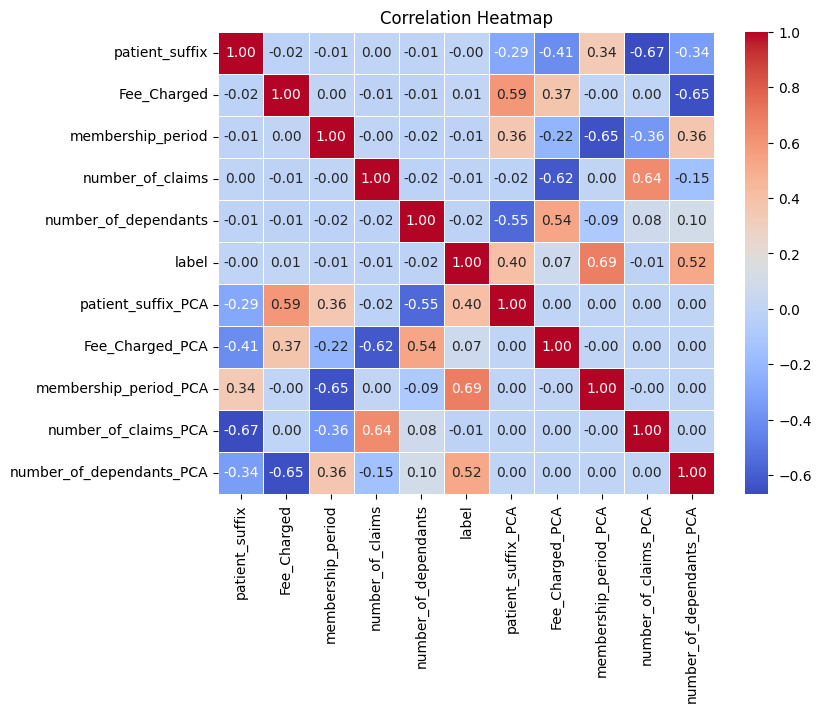

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns = final_df_with_actual_names.select_dtypes(include=['float64', 'int64']).columns

# Create a correlation matrix
correlation_matrix = final_df_with_actual_names[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Show plot
plt.title('Correlation Heatmap')
plt.show()


In [7]:
!pip install scikit-multiflow

### AdaBoost

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
tree_classifier = DecisionTreeClassifier()

# Initialize AdaBoost with DecisionTree as base classifier
adaboost_classifier = AdaBoostClassifier(base_estimator=tree_classifier, n_estimators=50, learning_rate=0.1)

# Train the classifier
adaboost_classifier.fit(X_train, y_train)

# Predict using the trained AdaBoost classifier
predictions = adaboost_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Calculate Sensitivity and Specificity from the confusion matrix (assuming binary classification)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Accuracy: 0.995
Sensitivity: 0.9851301115241635
Specificity: 0.9973474801061007
Root Mean Squared Error (RMSE): 0.07071067811865475
Mean Absolute Error (MAE): 0.005


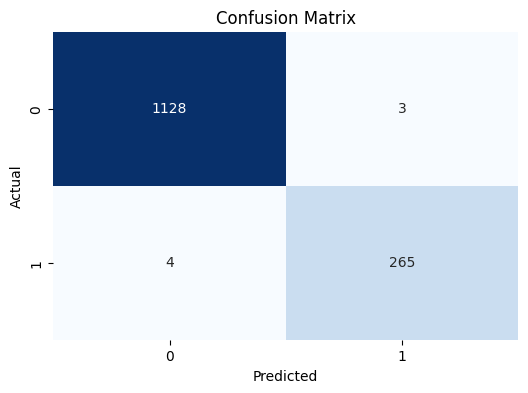

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

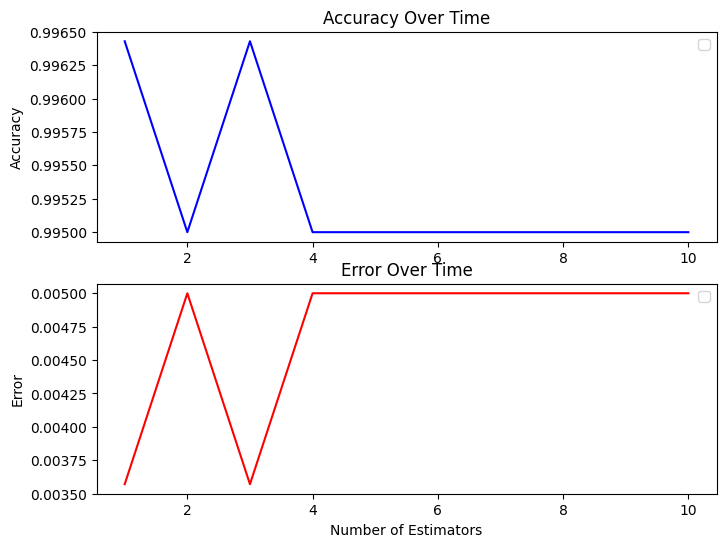

In [11]:

# Lists to store performance metrics over time
accuracy_over_time = []
error_over_time = []

# Train the classifier and evaluate at each iteration
for i in range(1, 11):
    adaboost_classifier.n_estimators = i
    adaboost_classifier.fit(X_train, y_train)
    predictions = adaboost_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    error = mean_squared_error(y_test, predictions)

    # Append metrics to lists
    accuracy_over_time.append(accuracy)
    error_over_time.append(error)

# Create subplots for accuracy and error
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot accuracy
ax1.plot(range(1, 11), accuracy_over_time, color='blue')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Over Time')
ax1.legend()

# Plot error
ax2.plot(range(1, 11), error_over_time, color='red')
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('Error')
ax2.set_title('Error Over Time')
ax2.legend()

plt.show()

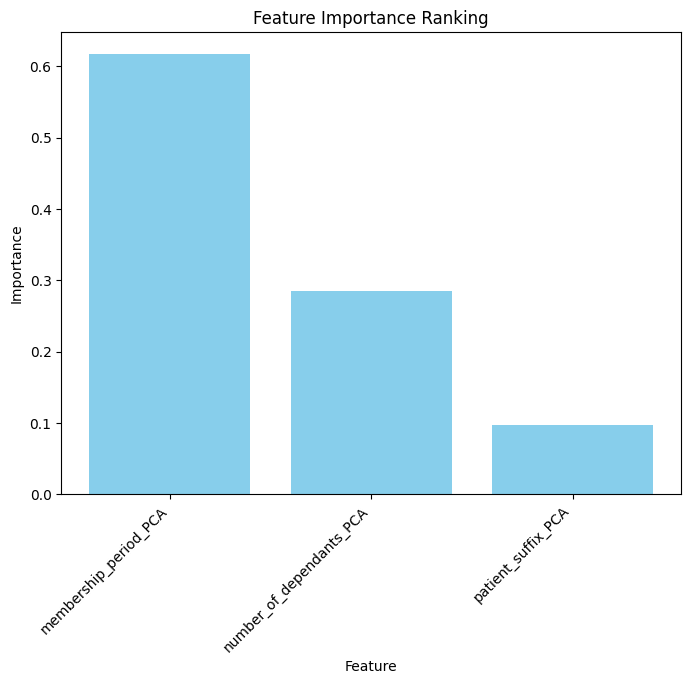

In [12]:
import matplotlib.pyplot as plt

# Get feature importances from the trained AdaBoost classifier
feature_importances = adaboost_classifier.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Bar chart for Feature Importance Ranking with feature names on the x-axis
plt.figure(figsize=(8, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Ranking')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


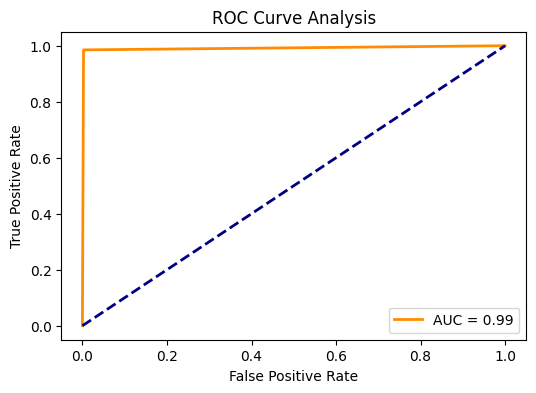

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probabilities = adaboost_classifier.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis')
plt.legend(loc='lower right')
plt.show()


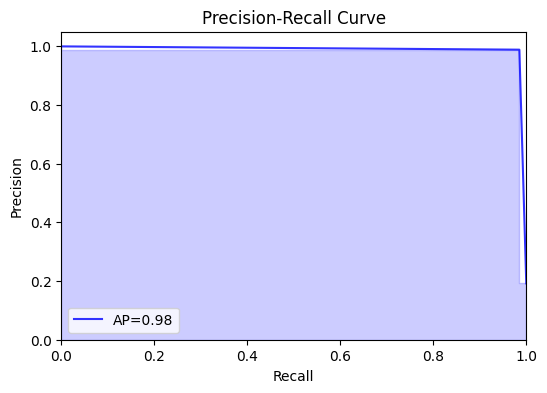

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probabilities = adaboost_classifier.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_probabilities)

# Calculate the area under the precision-recall curve (AUC)
average_precision = average_precision_score(y_test, y_probabilities)

# Plot Precision Curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='b', alpha=0.8, label=f'AP={average_precision:.2f}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


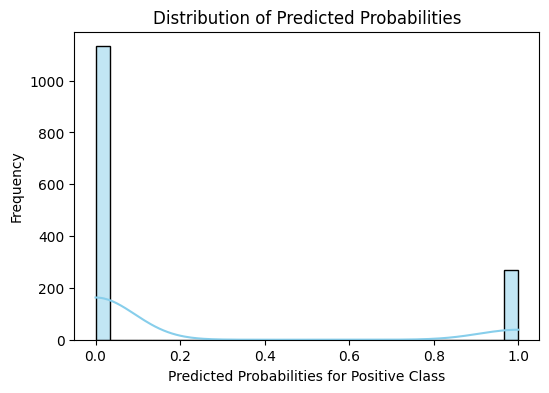

In [15]:
# Get predicted probabilities for the positive class
predicted_probabilities = adaboost_classifier.predict_proba(X_test)[:, 1]

# Plotting Histogram
plt.figure(figsize=(6, 4))
sns.histplot(predicted_probabilities, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probabilities for Positive Class')
plt.ylabel('Frequency')
plt.show()

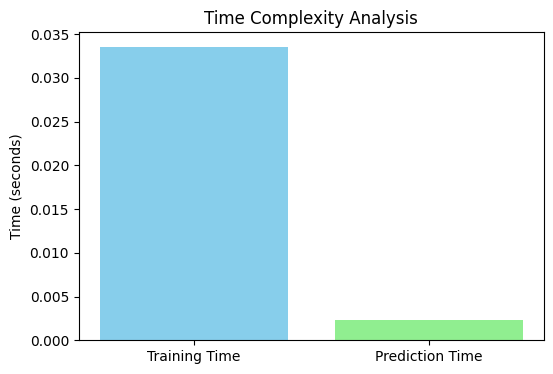

In [16]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Measure training time
start_time = time.time()
adaboost_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
predictions = adaboost_classifier.predict(X_test)
prediction_time = time.time() - start_time

# Plotting Bar Chart
labels = ['Training Time', 'Prediction Time']
times = [training_time, prediction_time]

plt.figure(figsize=(6, 4))
plt.bar(labels, times, color=['skyblue', 'lightgreen'])
plt.ylabel('Time (seconds)')
plt.title('Time Complexity Analysis')
plt.show()


### DecisionTree

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
tree_classifier = DecisionTreeClassifier()

# Train the classifier
tree_classifier.fit(X_train, y_train)

# Predict using the trained Decision Tree classifier
predictions = tree_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Calculate Sensitivity and Specificity from the confusion matrix (assuming binary classification)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Accuracy: 0.9957142857142857
Sensitivity: 0.9888475836431226
Specificity: 0.9973474801061007
Root Mean Squared Error (RMSE): 0.06546536707079771
Mean Absolute Error (MAE): 0.004285714285714286


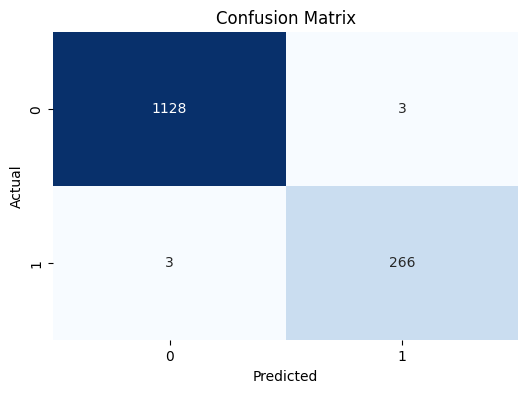

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

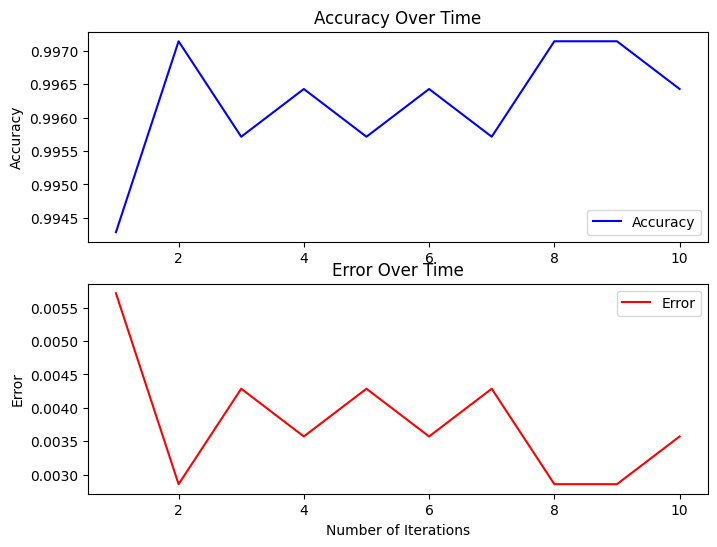

In [19]:
# Lists to store performance metrics over time
accuracy_over_time = []
error_over_time = []

# Train the classifier and evaluate at each iteration
for i in range(1, 11):
    tree_classifier.fit(X_train, y_train)
    predictions = tree_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    error = mean_squared_error(y_test, predictions)

    # Append metrics to lists
    accuracy_over_time.append(accuracy)
    error_over_time.append(error)

# Create subplots for accuracy and error
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot accuracy
ax1.plot(range(1, 11), accuracy_over_time, label='Accuracy', color='blue')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Over Time')
ax1.legend()

# Plot error
ax2.plot(range(1, 11), error_over_time, label='Error', color='red')
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('Error')
ax2.set_title('Error Over Time')
ax2.legend()

plt.show()

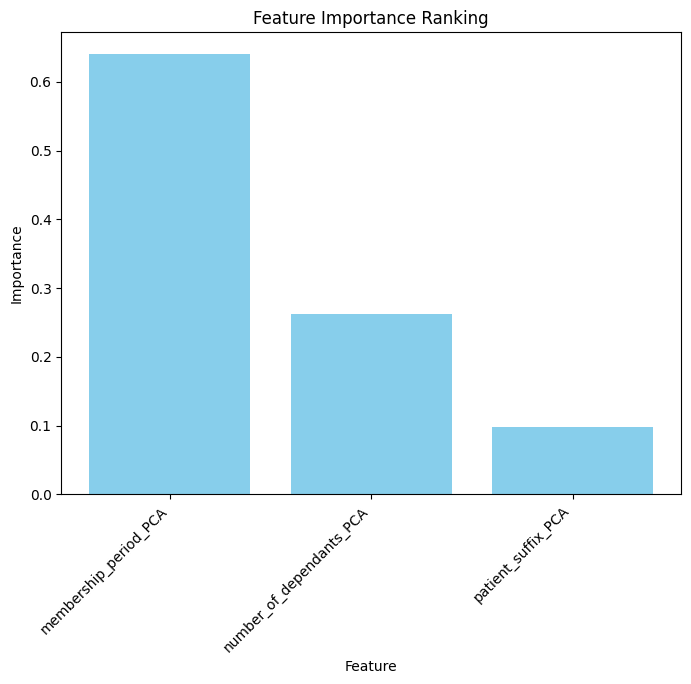

In [20]:
import matplotlib.pyplot as plt

# Get feature importances from the trained AdaBoost classifier
feature_importances = tree_classifier.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Bar chart for Feature Importance Ranking with feature names on the x-axis
plt.figure(figsize=(8, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Ranking')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


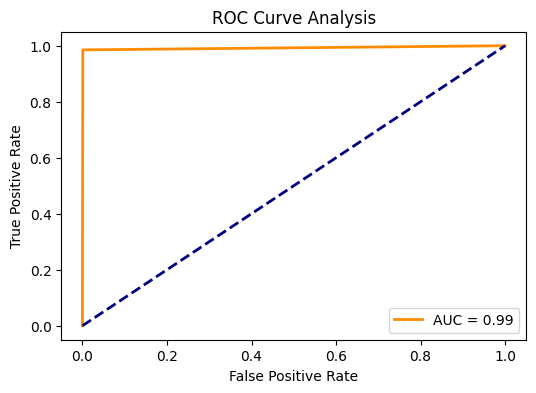

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probabilities = tree_classifier.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis')
plt.legend(loc='lower right')
plt.show()


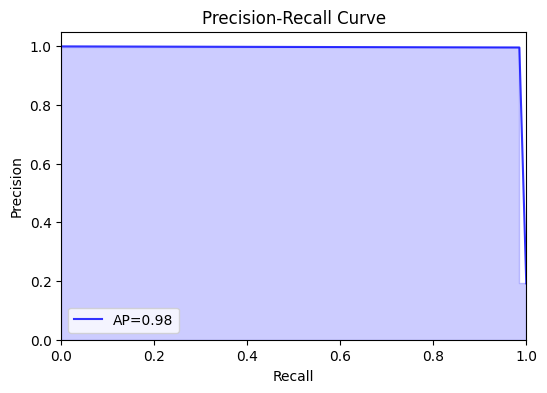

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probabilities = tree_classifier.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_probabilities)

# Calculate the area under the precision-recall curve (AUC)
average_precision = average_precision_score(y_test, y_probabilities)

# Plot Precision Curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='b', alpha=0.8, label=f'AP={average_precision:.2f}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


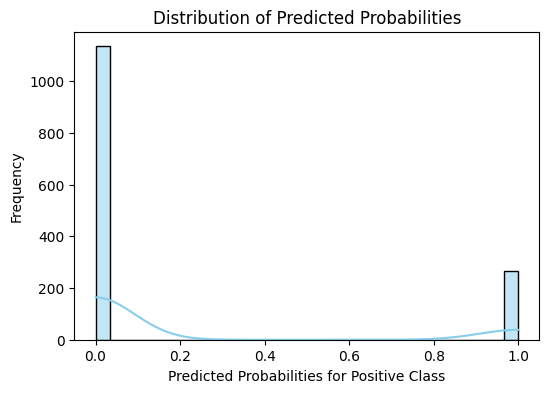

In [23]:
# Get predicted probabilities for the positive class
predicted_probabilities = tree_classifier.predict_proba(X_test)[:, 1]

# Plotting Histogram
plt.figure(figsize=(6, 4))
sns.histplot(predicted_probabilities, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probabilities for Positive Class')
plt.ylabel('Frequency')
plt.show()

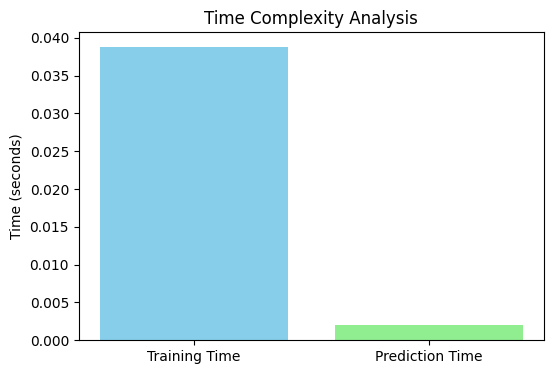

In [24]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Measure training time
start_time = time.time()
tree_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
predictions = tree_classifier.predict(X_test)
prediction_time = time.time() - start_time

# Plotting Bar Chart
labels = ['Training Time', 'Prediction Time']
times = [training_time, prediction_time]

plt.figure(figsize=(6, 4))
plt.bar(labels, times, color=['skyblue', 'lightgreen'])
plt.ylabel('Time (seconds)')
plt.title('Time Complexity Analysis')
plt.show()


### GaussianNB

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error


# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Predict using the trained Naive Bayes classifier
predictions = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Calculate Sensitivity and Specificity from the confusion matrix (assuming binary classification)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Accuracy: 0.9978571428571429
Sensitivity: 0.9888475836431226
Specificity: 1.0
Root Mean Squared Error (RMSE): 0.04629100498862757
Mean Absolute Error (MAE): 0.002142857142857143


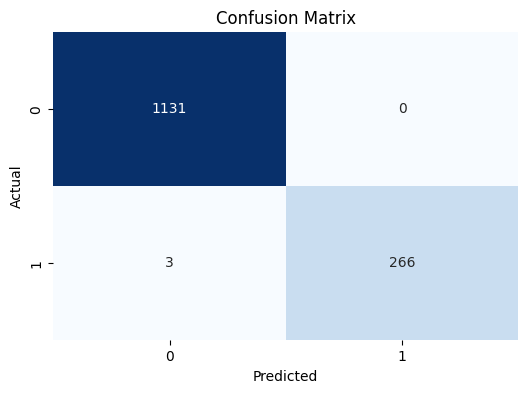

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

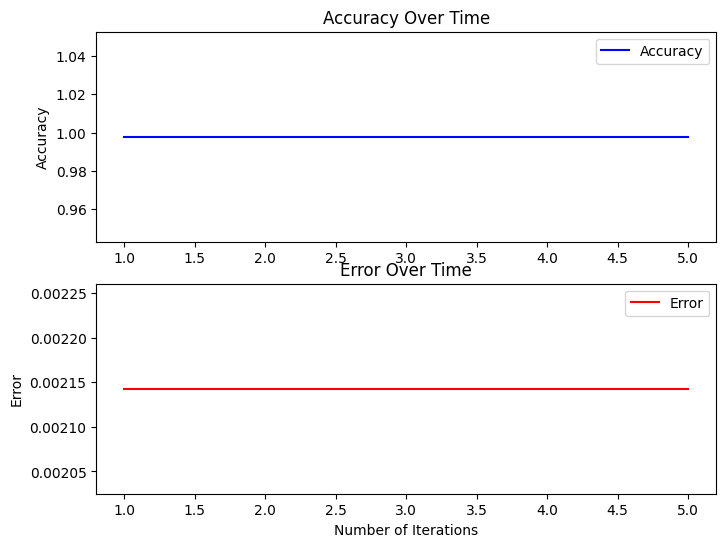

In [27]:

# Lists to store performance metrics over time
accuracy_over_time = []
error_over_time = []

# Train the classifier and evaluate at each iteration
for i in range(1, 6):
    nb_classifier.fit(X_train, y_train)
    predictions = nb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    error = mean_squared_error(y_test, predictions)

    # Append metrics to lists
    accuracy_over_time.append(accuracy)
    error_over_time.append(error)

# Create subplots for accuracy and error
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot accuracy
ax1.plot(range(1, 6), accuracy_over_time, label='Accuracy', color='blue')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Over Time')
ax1.legend()

# Plot error
ax2.plot(range(1, 6), error_over_time, label='Error', color='red')
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('Error')
ax2.set_title('Error Over Time')
ax2.legend()

plt.show()

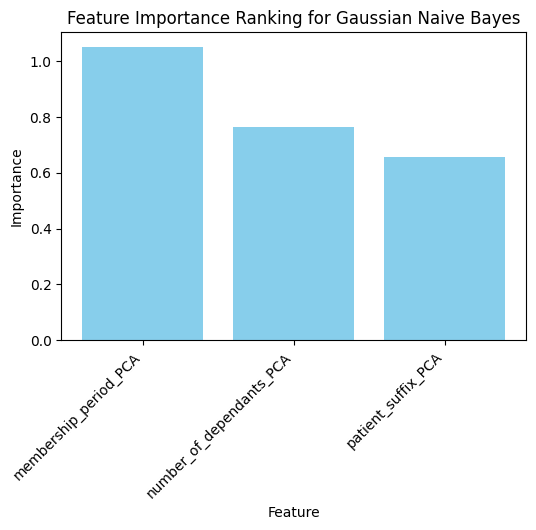

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Get mean values from the trained Gaussian Naive Bayes classifier
feature_means = nb_classifier.theta_

# Calculate the overall importance of each feature (sum of mean values across all classes)
overall_importance = np.sum(feature_means, axis=0)

# Create a DataFrame with feature names and their overall importances
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': overall_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Bar chart for Feature Importance Ranking
plt.figure(figsize=(6, 4))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Ranking for Gaussian Naive Bayes')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


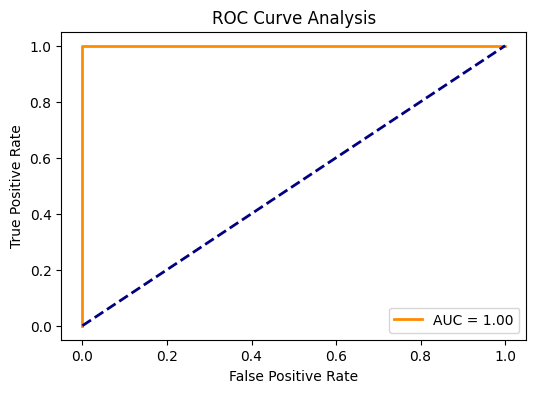

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probabilities = nb_classifier.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis')
plt.legend(loc='lower right')
plt.show()


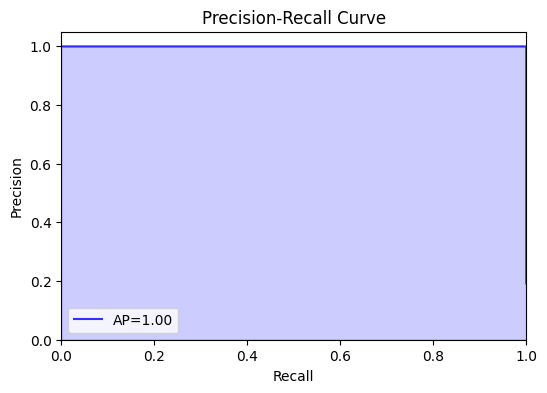

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probabilities = nb_classifier.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_probabilities)

# Calculate the area under the precision-recall curve (AUC)
average_precision = average_precision_score(y_test, y_probabilities)

# Plot Precision Curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='b', alpha=0.8, label=f'AP={average_precision:.2f}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


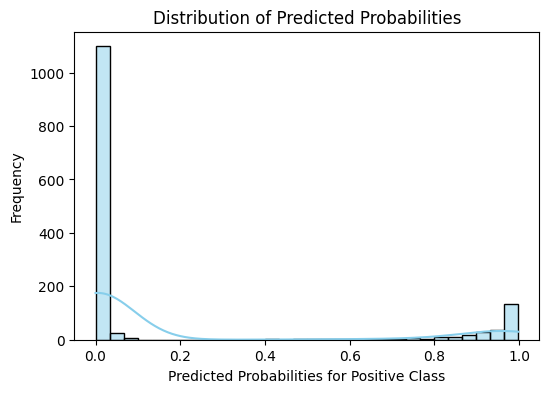

In [31]:
# Get predicted probabilities for the positive class
predicted_probabilities = nb_classifier.predict_proba(X_test)[:, 1]

# Plotting Histogram
plt.figure(figsize=(6, 4))
sns.histplot(predicted_probabilities, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probabilities for Positive Class')
plt.ylabel('Frequency')
plt.show()

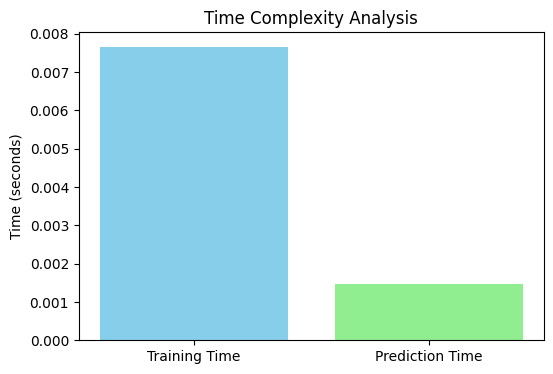

In [32]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Measure training time
start_time = time.time()
nb_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
predictions = nb_classifier.predict(X_test)
prediction_time = time.time() - start_time

# Plotting Bar Chart
labels = ['Training Time', 'Prediction Time']
times = [training_time, prediction_time]

plt.figure(figsize=(6, 4))
plt.bar(labels, times, color=['skyblue', 'lightgreen'])
plt.ylabel('Time (seconds)')
plt.title('Time Complexity Analysis')
plt.show()


### GradientBoosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the classifier
gb_classifier.fit(X_train, y_train)

# Predict using the trained Gradient Boosting classifier
predictions = gb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Calculate Sensitivity and Specificity from the confusion matrix (assuming binary classification)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Accuracy: 0.9992857142857143
Sensitivity: 0.9962825278810409
Specificity: 1.0
Root Mean Squared Error (RMSE): 0.02672612419124244
Mean Absolute Error (MAE): 0.0007142857142857143


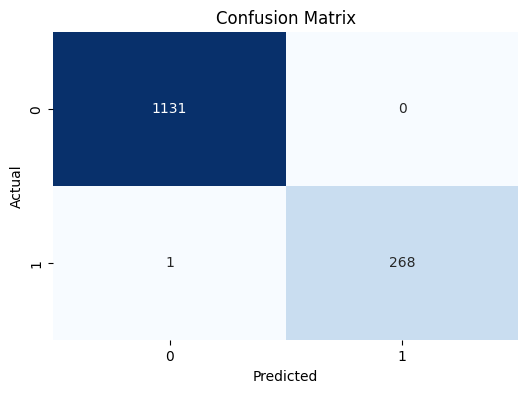

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

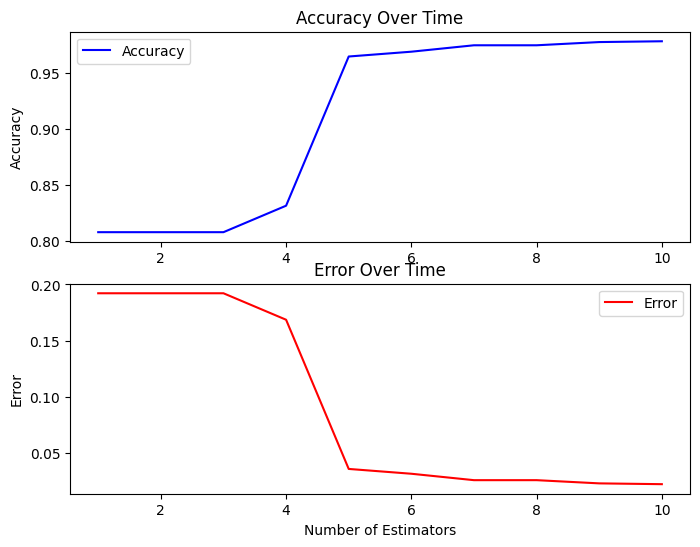

In [35]:
# Lists to store performance metrics over time
accuracy_over_time = []
error_over_time = []

# Train the classifier and evaluate at each iteration
for i in range(1, 11):  # Assuming 100 iterations (you can adjust as needed)
    gb_classifier.n_estimators = i
    gb_classifier.fit(X_train, y_train)
    predictions = gb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    error = mean_squared_error(y_test, predictions)

    # Append metrics to lists
    accuracy_over_time.append(accuracy)
    error_over_time.append(error)

# Create subplots for accuracy and error
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot accuracy
ax1.plot(range(1, 11), accuracy_over_time, label='Accuracy', color='blue')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Over Time')
ax1.legend()

# Plot error
ax2.plot(range(1, 11), error_over_time, label='Error', color='red')
ax2.set_xlabel('Number of Estimators')
ax2.set_ylabel('Error')
ax2.set_title('Error Over Time')
ax2.legend()

plt.show()

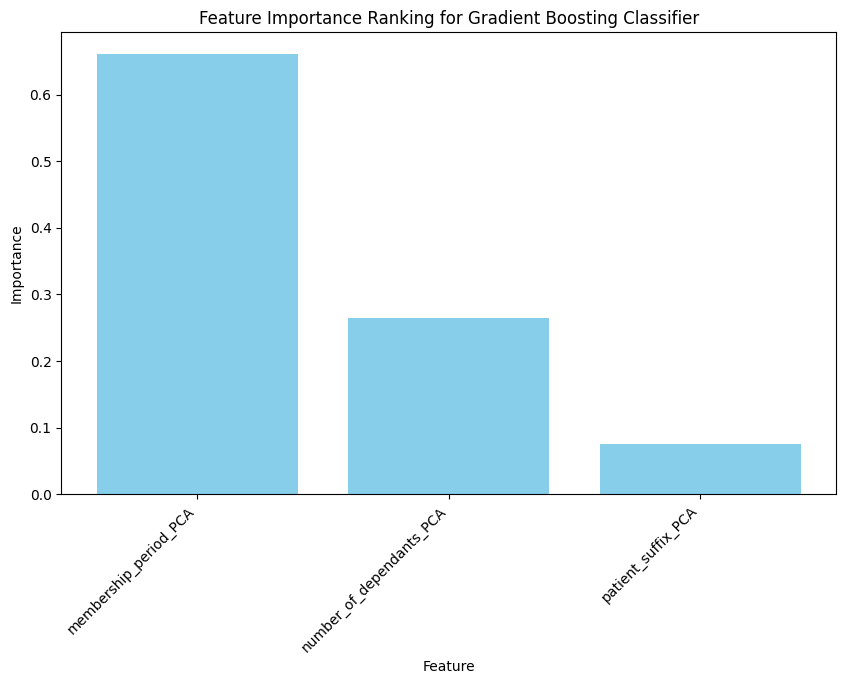

In [36]:
import matplotlib.pyplot as plt

# Get feature importances from the trained Gradient Boosting classifier
feature_importances = gb_classifier.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Bar chart for Feature Importance Ranking
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Ranking for Gradient Boosting Classifier')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


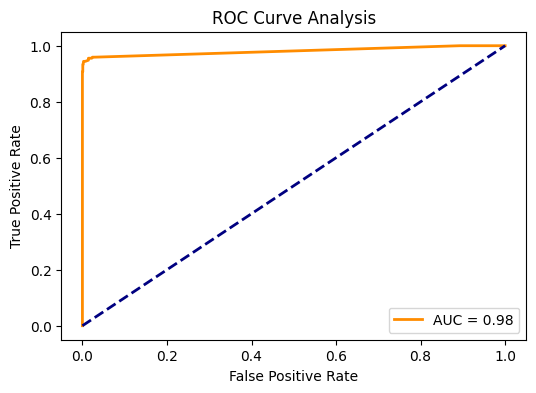

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probabilities = gb_classifier.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Analysis')
plt.legend(loc='lower right')
plt.show()


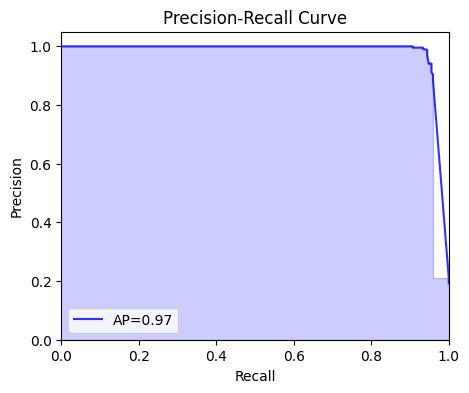

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probabilities = gb_classifier.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_probabilities)

# Calculate the area under the precision-recall curve (AUC)
average_precision = average_precision_score(y_test, y_probabilities)

# Plot Precision Curve
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='b', alpha=0.8, label=f'AP={average_precision:.2f}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


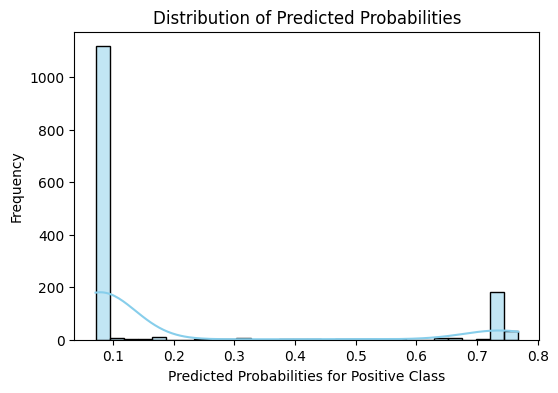

In [39]:
# Get predicted probabilities for the positive class
predicted_probabilities = gb_classifier.predict_proba(X_test)[:, 1]

# Plotting Histogram
plt.figure(figsize=(6, 4))
sns.histplot(predicted_probabilities, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probabilities for Positive Class')
plt.ylabel('Frequency')
plt.show()

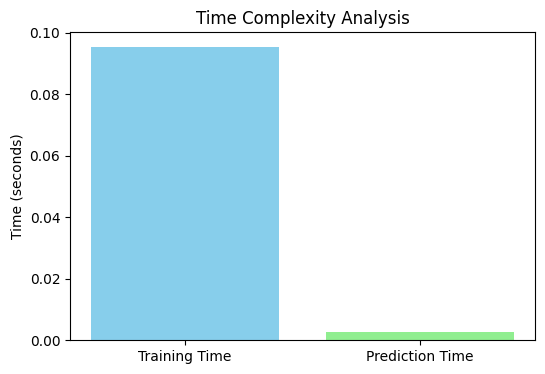

In [40]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Measure training time
start_time = time.time()
gb_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
predictions = gb_classifier.predict(X_test)
prediction_time = time.time() - start_time

# Plotting Bar Chart
labels = ['Training Time', 'Prediction Time']
times = [training_time, prediction_time]

plt.figure(figsize=(6, 4))
plt.bar(labels, times, color=['skyblue', 'lightgreen'])
plt.ylabel('Time (seconds)')
plt.title('Time Complexity Analysis')
plt.show()


### Ensemble Model

In [41]:
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

# Splitting data into features and target
X = final_df_with_actual_names[selected_features]
y = final_df_with_actual_names['label']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize individual classifiers
ada_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42)
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)
gnb_classifier = GaussianNB()
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Create a voting ensemble using the individual classifiers
voting_classifier = VotingClassifier(
    estimators=[
        ('AdaBoost', ada_classifier),
        ('DecisionTree', dt_classifier),
        ('GaussianNB', gnb_classifier),
        ('GradientBoosting', gb_classifier)
    ],
    voting='hard'  # 'hard' voting takes the majority of votes, 'soft' voting computes the argmax of the sums of predicted probabilities
)

# Train the voting ensemble
voting_classifier.fit(X_train, y_train)

# Predict using the trained voting ensemble
predictions = voting_classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print("Metrics for Voting Classifier:")
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Metrics for Voting Classifier:
Accuracy: 0.9985714285714286
Sensitivity: 0.9925650557620818
Specificity: 1.0
Root Mean Squared Error (RMSE): 0.03779644730092272
Mean Absolute Error (MAE): 0.0014285714285714286


### Confusion Matrix

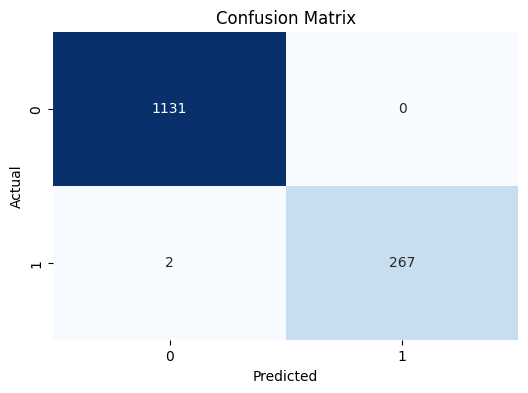

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plotting confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Weightage

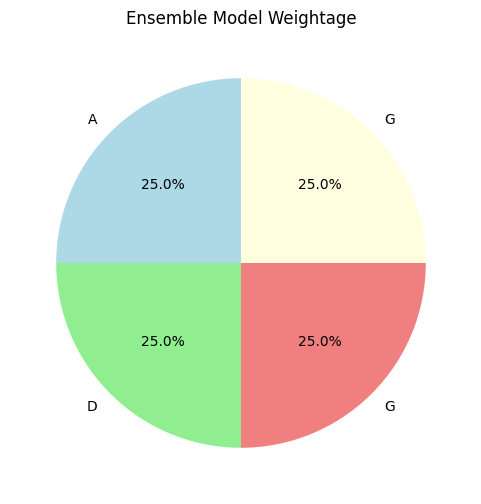

In [43]:
import matplotlib.pyplot as plt

# Get the weights assigned to each classifier in the ensemble
classifier_weights = [estimator[1].n_estimators_ if hasattr(estimator[1], 'n_estimators_') else 1 for estimator in voting_classifier.estimators]

# Extract names and weights
classifier_names = [estimator[0] for estimator in voting_classifier.named_estimators]

# Plotting Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(classifier_weights, labels=classifier_names, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.title('Ensemble Model Weightage')
plt.show()


### Compare Analysis

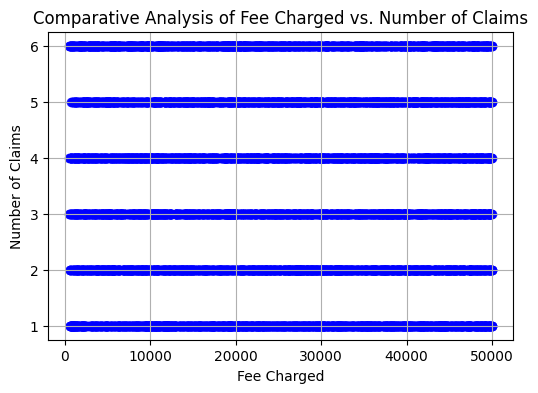

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Scatter plot for Comparative Analysis of Fee Charged vs. Number of Claims
plt.figure(figsize=(6, 4))
plt.scatter(data['Fee_Charged'], data['number_of_claims'], color='blue', alpha=0.8)
plt.title('Comparative Analysis of Fee Charged vs. Number of Claims')
plt.xlabel('Fee Charged')
plt.ylabel('Number of Claims')
plt.grid(True)
plt.show()

### Trend Analysis

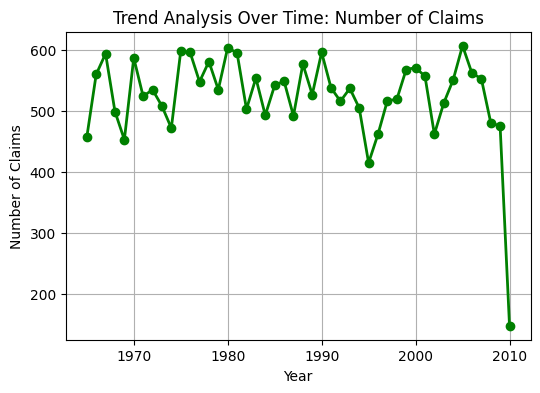

In [45]:
# Line graph for Trend Analysis Over Time: Number of Claims
data['patient_dob'] = pd.to_datetime(data['patient_dob'], errors='coerce')
data['claim_year'] = data['patient_dob'].dt.year

claim_trends = data.groupby('claim_year')['number_of_claims'].sum().reset_index()

plt.figure(figsize=(6, 4))
plt.plot(claim_trends['claim_year'], claim_trends['number_of_claims'], marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Trend Analysis Over Time: Number of Claims')
plt.xlabel('Year')
plt.ylabel('Number of Claims')
plt.grid(True)
plt.show()

### Model comparsion

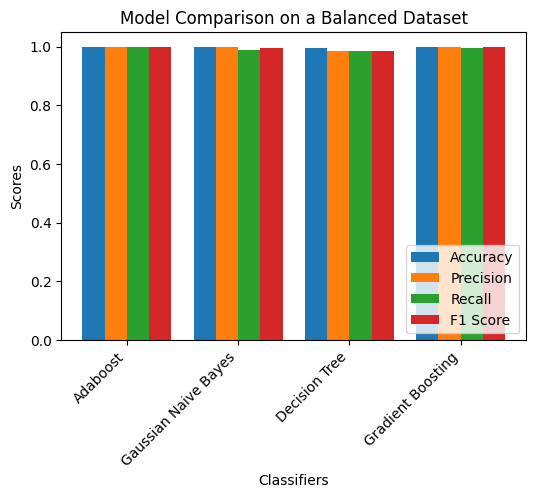

In [46]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Initialize classifiers
classifiers = {
    'Adaboost': AdaBoostClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Initialize dictionaries to store results
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Train and evaluate each model
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy_scores[clf_name] = accuracy_score(y_test, y_pred)
    precision_scores[clf_name] = precision_score(y_test, y_pred)
    recall_scores[clf_name] = recall_score(y_test, y_pred)
    f1_scores[clf_name] = f1_score(y_test, y_pred)

# Plot the comparison graph
fig, ax = plt.subplots(figsize=(6, 4))

# Bar width
bar_width = 0.2
index = range(len(classifiers))

# Plot metrics for each classifier
ax.bar(index, accuracy_scores.values(), width=bar_width, label='Accuracy')
ax.bar([i + bar_width for i in index], precision_scores.values(), width=bar_width, label='Precision')
ax.bar([i + 2 * bar_width for i in index], recall_scores.values(), width=bar_width, label='Recall')
ax.bar([i + 3 * bar_width for i in index], f1_scores.values(), width=bar_width, label='F1 Score')

# Set labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison on a Balanced Dataset')
ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(classifiers.keys(), rotation=45, ha='right')

# Position the legend at the upper right corner
ax.legend(loc='lower right')

# Show the plot
plt.show()
